In [1]:
import sys
import os
sys.path.append("..")

import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, jit, vmap
import numpyro
from numpyro import distributions as dist
from numpyro import infer

from numpyro_ext import distributions as distx
from numpyro_ext import info, optim

jax.config.update("jax_enable_x64", True)
numpyro.set_host_device_count(2)

from jaxoplanet import light_curves, orbits
import arviz as az
import corner

from core.jax import oblate_lightcurve
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=40"
numpyro.enable_x64()

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


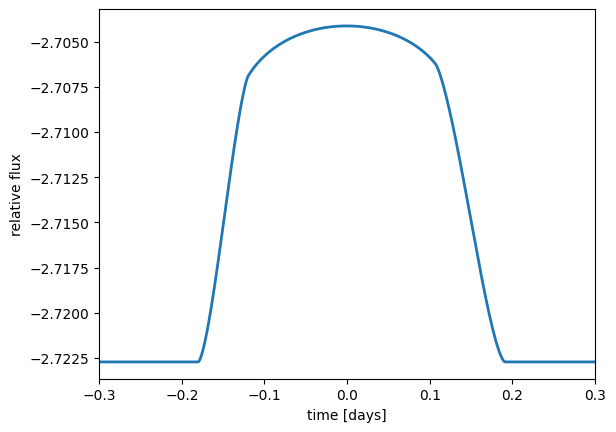

In [6]:
#Fiducial planet parameters:
params = {'period':300.456,
          'radius':0.1,
          'u':jnp.array([0.3,0.2]),
          'f':0.3,
          'bo':0.8,
          'theta':jnp.radians(35)
}
# The light curve calculation requires an orbit

# Compute a limb-darkened light curve using starry
t = jnp.linspace(-0.3, 0.3, 1000)
oblate_lightcurve = jit(oblate_lightcurve)
lc = oblate_lightcurve(params,t)

plt.plot(t, lc, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

{'period': 7.704045333151538, 't0': 1.0, 'radius': 0.1, 'bo': 0.8, 'u': Array([0.3, 0.2], dtype=float64), 'f': 0.3, 'theta': 0.6108652381980153}


Text(0.5, 0, 'Time')

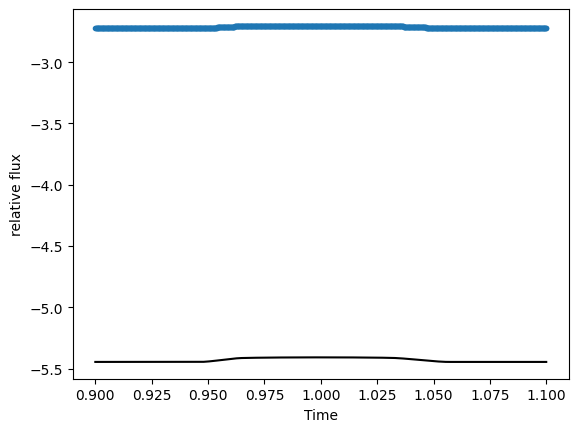

In [3]:
np.random.seed(11)
period_true = np.random.uniform(5, 20)
t = np.linspace(0.9,1.1,1000)
yerr = 50*1e-6

true_params = {'period':period_true,
               't0':1.0,
                'radius':0.1,
                'bo':0.8,
                'u':jnp.array([0.3, 0.2]),
                'f':0.3,
                'theta':np.radians(35)
} 

print(true_params)

# Compute a limb-darkened light curve using starry
lc_true = oblate_lightcurve(true_params, t-true_params['t0'])

lc = lc_true + yerr*np.random.normal(size=len(t))

ax = plt.subplot()
ax.plot(t, lc, 'C0.')
ax.plot(t, 2*lc_true, color='k')
ax.set_ylabel("relative flux")
ax.set_xlabel("Time")

In [5]:
def u_to_q(u1,u2):
    q1 = (u1 + u2)**2
    q2 = 0.5*u1*(u1 + u2)**(-1)
    return q1,q2
def q_to_u(q1, q2): 
    u1 = 2.*jnp.sqrt(jnp.abs(q1))*q2
    u2 = jnp.sqrt(jnp.abs(q1))*(1.-2.*q2)
    return u1,u2
u_to_q(0.3,0.2)

In [58]:
numpyro.enable_x64()

def model(t, yerr, y=None):
    # If we wanted to fit for all the parameters, we could use the following,
    # but we'll keep these fixed for simplicity.
    
    #log_duration = numpyro.sample("log_duration", dist.Uniform(jnp.log(0.08), jnp.log(0.2)))
    #b = numpyro.sample("b", dist.Uniform(0.0, 1.0))

    log_jitter = numpyro.sample("log_jitter", dist.Normal(jnp.log(yerr), 1.0))
    log_r = numpyro.sample("log_r", dist.Normal(jnp.log(0.1), 2.0))
    r = numpyro.deterministic("r", jnp.exp(log_r))
    q1 = numpyro.sample("q1", dist.Normal(0.25, 0.1))
    q2 = numpyro.sample("q2", dist.Normal(0.3, 0.1))
    bo = numpyro.sample("bo", dist.Uniform(0.0,1.0))
    f = numpyro.sample("f", dist.Uniform(0.0,1.0))
    theta = numpyro.sample("theta", dist.Uniform(0.0,jnp.pi))
    u1,u2 = numpyro.deterministic("u",q_to_u(q1,q2))
    params = {
        'period':period_true,
        't0': 1.0,
        "radius": r,
        'bo':bo,
        'u': jnp.array([u1,u2]),
        'f':f, 
        'theta':theta       
    }

    numpyro.sample(
        "flux",
        dist.Normal(
            oblate_lightcurve(params, t-true_params['t0']), jnp.sqrt(yerr**2 + jnp.exp(2 * log_jitter))
        ),
        obs=y,
    )

### Oblate MCMC Fit

In [10]:
init_params = {'period':period_true,
                't0':1.0,
                'log_r':jnp.log(true_params['radius']),
                'u':jnp.array([0.3, 0.2]),
                'f':0.1,
                'bo':0.7,
                'theta':jnp.radians(0)
               
} 

In [ ]:
sampler_wn = infer.MCMC(
    infer.NUTS(
        model,
        target_accept_prob=0.9,
        dense_mass=False,
        init_strategy=infer.init_to_value(values=init_params),
        regularize_mass_matrix=False,
    ),
    num_warmup=1000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler_wn.run(jax.random.PRNGKey(11), t, yerr, lc)

In [ ]:
inf_data_wn = az.from_numpyro(sampler_wn)
az.summary(inf_data_wn, var_names=["log_jitter", "log_r", "u1", "u2", "bo", "f", "theta"])

### Oblate Nested Sampling Fit

In [13]:
from numpyro.contrib.nested_sampling import NestedSampler
from jaxns.prior_transforms.prior import UniformBase

In [14]:
ns = NestedSampler(model,constructor_kwargs={'num_parallel_samplers':40})
ns.run(jax.random.PRNGKey(2), t, yerr, lc)

ns_samples = ns.get_samples(jax.random.PRNGKey(121), num_samples=10000)

WARNING[2023-10-11 20:15:27,861]: Increasing max_samples (100000) by 100 to evenly divide samples_per_step


In [15]:
inf_data = az.from_dict(ns_samples, dropna=True)
az.summary(inf_data, var_names=["log_jitter", "log_r", "u1", "u2", "bo", "f", "theta"])


arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_jitter,-1.694,0.0,-1.694,-1.694,0.0,0.0,10000.0,10000.0,NaN
log_r,0.553,0.0,0.553,0.553,0.0,0.0,9757.0,9561.0,NaN
u1,0.304,0.0,0.304,0.304,0.0,0.0,9786.0,9360.0,NaN
u2,0.079,0.0,0.079,0.079,0.0,0.0,9785.0,9568.0,NaN
bo,0.446,0.0,0.446,0.446,0.0,0.0,9577.0,9541.0,NaN
f,0.243,0.0,0.243,0.243,0.0,0.0,9651.0,9631.0,NaN
theta,1.869,0.0,1.869,1.869,0.0,0.0,10239.0,10077.0,NaN


In [21]:
import matplotlib as mpl
def plot_corner_diagnostics(samples, param_true):
    mpl.rcParams['font.size'] = 12
    ndim = len(samples.keys())
    # This is the empirical mean of the sample:
    value2 = np.mean(np.array(list(samples.values())),axis=1)
    #True
    value1 = param_true

    # Make the base corner plot
    # 68% et 95% quantiles 1D et levels in 2D
    figure = corner.corner(samples,quantiles=(0.025, 0.158655, 0.841345, 0.975), levels=(0.68,0.95), 
                        show_titles=True, title_kwargs={"fontsize": 12}, 
                        truths=param_true, truth_color='g', color='b'
                        );

    # Extract the axes
    axes = np.array(figure.axes).reshape((ndim, ndim))

    # Loop over the diagonal
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(value2[i], color="r")
    
    # Loop over the histograms
    for idy in range(ndim):
        for idx in range(idy):
            ax = axes[idy, idx]
            ax.axvline(value2[idx], color="r")
            ax.axhline(value2[idy], color="r")
            ax.plot(value2[idx], value2[idy], "sr")

    plt.show()

TypeError: <lambda>() takes 1 positional argument but 6 were given

In [34]:
flat_samples = []
truth_list = []
for i,v in enumerate(varnames):
    flat_samples_i = ns_samples[v]
    flat_samples.append(flat_samples_i)
flat_samples = np.array(flat_samples)


WARNING[2023-10-16 14:51:10,564]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,590]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,610]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,635]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,651]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,665]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,687]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,703]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,718]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,732]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,756]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,771]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,786]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,801]: Too 

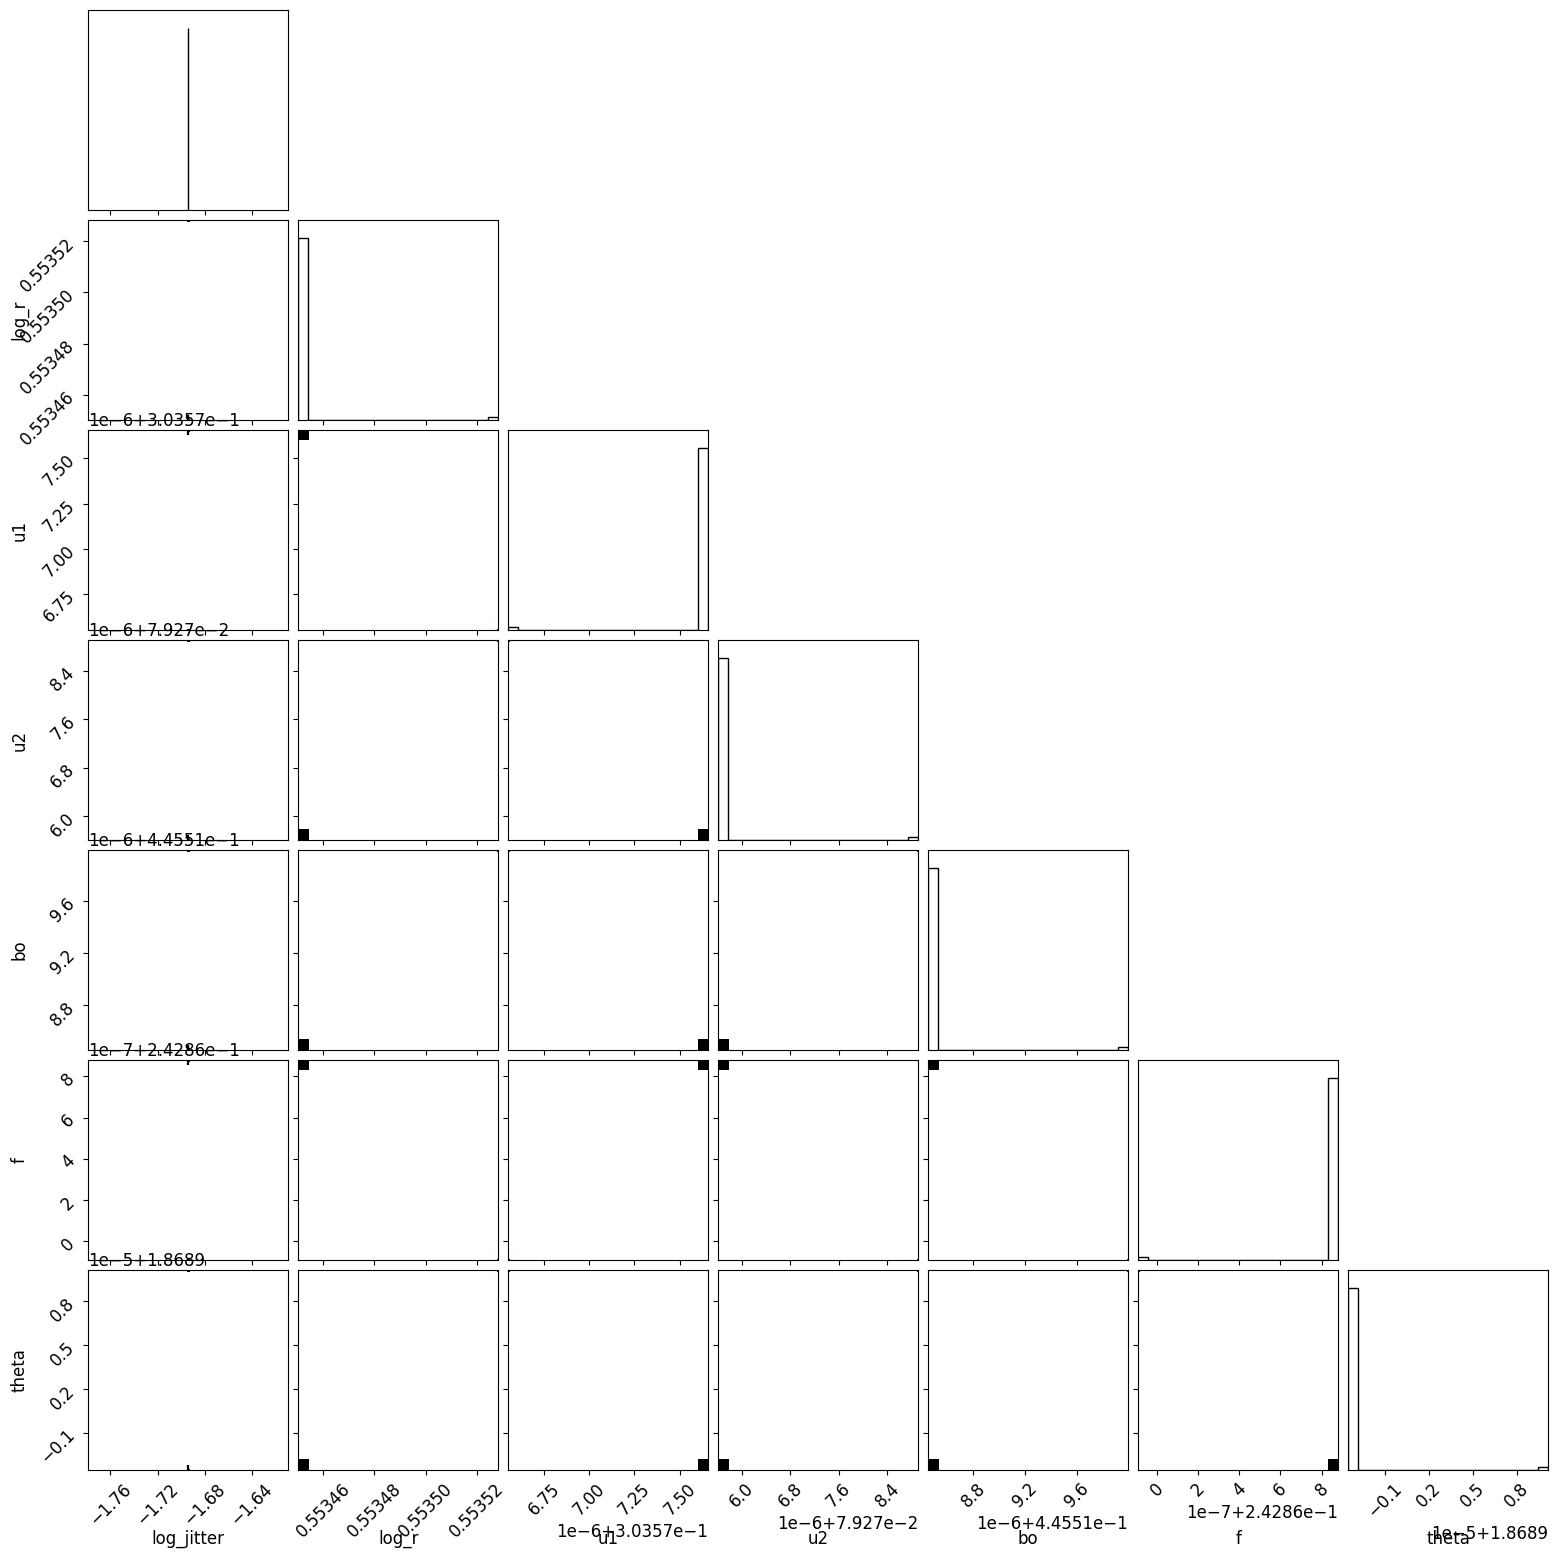

In [47]:
import corner
varnames = ["log_jitter", "log_r", "u1", "u2", "bo", "f", "theta"]
fig = corner.corner(flat_samples.T,range=[0.001,1,1,1,1,1,1],labels=varnames,truth=[yerr,jnp.log(true_params['radius']),true_params['u'][0],true_params['u'][1],true_params['bo'],true_params['f'],true_params['theta']])
plt.savefig('oblate_corner.png')

In [55]:
[yerr,jnp.log(true_params['radius']),true_params['u'][0],true_params['u'][1],true_params['bo'],true_params['f'],true_params['theta']]
np.degrees(np.mean(flat_samples.T[:,6]))

107.07989312215959